In [2]:
import csv
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

In [3]:
#Load in the CSV Bike Station Location Data
df = pd.read_csv('HRSQ12020.csv')
df

,Station #,Station Name,NumRacks,Latitude,Longitude
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080
2,1002,Third Ave & Wood St,15,40.439030,-80.001860
3,1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102
...,...,...,...,...,...
95,49781,Fifth Ave & Miltenberger,6,40.438296,-79.981177
96,49801,Microsoft,6,40.453797,-79.990940
97,49881,Arch St & Jacksonia St,5,40.457773,-80.009458
98,49921,W General Robinson St & Chuck Noll Way,5,40.447412,-80.012065


In [4]:
#fixing wrong negative value for Latitude
df.loc[df["Latitude"] == df["Latitude"].min()]
df.at[80, 'Latitude'] = 40.467715

geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
crs = {'init' :'epsg:4326'}
geobikes = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
geobikes.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Station #,Station Name,NumRacks,Latitude,Longitude,geometry
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679,POINT (-80.00468 40.44133)
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080,POINT (-80.00308 40.44088)
2,1002,Third Ave & Wood St,15,40.439030,-80.001860,POINT (-80.00186 40.43903)
3,1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375,POINT (-80.00038 40.43720)
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102,POINT (-79.99710 40.43589)


In [5]:
#Load in the CSV median income by household data
housingdf = pd.read_csv('IncomeCensusData.csv', thousands=",")

#get only the neighborhood IDs that match to the Pittsburgh Neighborhood Map
housingdf = housingdf[housingdf.CensusTract != 0]

#change the neighborhood ids to be strings and have a 0 in front to match the other df output
housingdf['tractce10'] = str('')

for index, row in housingdf.iterrows():
    strVal = str(row['CensusTract'])
    strVals = strVal.split(".")
    if len(strVals[0]) < 6:
        strVals[0] = "0" + strVals[0]
    housingdf.at[index, 'tractce10'] = strVals[0]

In [6]:
#get the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')

for index, row in cenTract.iterrows():
    print(str(row["tractce10"]))

040500
040400
040200
030500
980000
020300
020100
262000
261500
261400
261200
260900
260700
563100
562400
981000
170200
180300
170600
010300
260200
180700
250900
562900
561900
130600
040900
562300
151700
151600
141400
141300
250300
241200
562000
080900
240600
220600
981800
080200
160800
101800
060300
080700
290400
981100
190300
101600
191100
191400
110600
141100
110200
101700
210700
980100
101100
140600
120400
191600
191700
101400
100500
090100
090200
090300
982200
191800
202300
563000
561600
561700
202200
980700
562700
562600
191900
080600
080400
070900
070800
300100
270800
981200
281400
281500
140500
290200
070600
070500
070300
060500
980600
140100
290100
051100
051000
050900
141000
140800
140400
191500
562500
310200
320400
140300
140200
271500
563200
192000
320600
320700
130400
130300
130200
270300
980400
481000
130100
120800
120700
980300
562800
120300
111500
310300
111400
111300
050600
980500
160900
050100
040600
270100
980900
250700
270400
980800


<ipython-input-9-00acb40b0c06>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cenTract["center"] = cenTract["geometry"].centroid


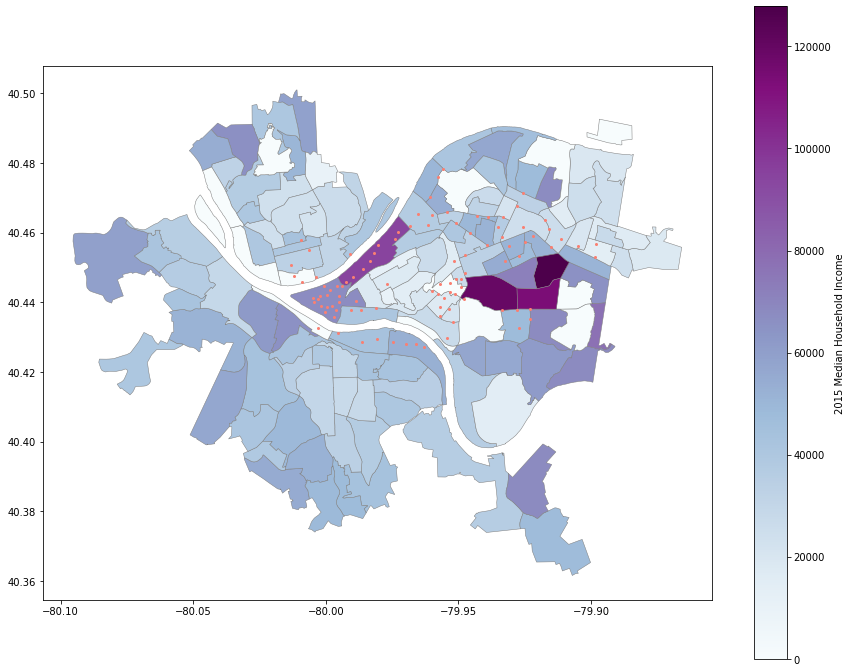

In [9]:

#find the centroids of each neighborhood for labeling
cenTract["center"] = cenTract["geometry"].centroid
map_points = cenTract.copy()
map_points.set_geometry("center", inplace = True)

#prep two merge the geodataframe and the dataframe together
pdf = cenTract.merge(housingdf, on='tractce10')

#plot the neighborhood ids on the map
ax = pdf.plot(column="2015TractMedianHouseHoldIncome", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", 
              linewidth = 0.5, legend = True, legend_kwds={'label': "2015 Median Household Income",'orientation': "vertical"})
texts = []

    
#now adding the bike station location data on top of this map. 
#result = plt.scatter(df['Longitude'], df['Latitude'], 15, marker='o', color='Purple')
result = geobikes.plot(ax=ax, color="salmon", markersize=4);

#save figure and label it
resultFig = result.get_figure()
resultFig.savefig("result1.png")